# Projeto #1 - Mineração de agrupamentos

<p style='text-align: justify;'><font size=3.>Análise de acidentes nas rodovias federais brasileira entre 2007 e 2021.</font></p>

### Bibliotecas básicas e outros imports

In [1]:
import warnings
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

%run modules/text.py

%matplotlib inline
plt.rcParams['font.family'] = 'Arial, Helvetica, sans-serif'

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
np.set_printoptions(suppress=True, precision=3)

### Carregamento dos dados

In [2]:
df = pd.read_csv('dataset/cluster_acidentes_rodovias_brasileiras_2007_a_2021.csv', low_memory=False, encoding='utf-8')
print(f'Linhas: {df.shape[0]} | Coluna:  {df.shape[1]}')
df.head(1)

Linhas: 1707393 | Coluna:  27


,id,dia_semana,uf,br,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,tipo_veiculo,tipo_envolvido,estado_fisico,idade,sexo,data,mes,ano,tipo_acidente_agrupado,fase_dia_agrupado,dia_semana_agrupado,condicao_metereologica_agrupado,porte_veiculo
0,83123216.0,quarta,SC,101,Balneario Camboriu,nao guardar distancia de seguranca,colisao traseira,sem vitimas,plena noite,decrescente,chuva,simples,reta,urbano,automovel,condutor,ileso,29,masculino,2014-01-01,1,2014,colisão,noite,dia útil,tempo ruim,pequeno porte


### Categorização da variável idade

> <p style='text-align: justify;'><font size=2.85>Categorização realizada de acordo com o estatuto da criança e adolescente (ECA).</font></p>

| faixa | categoria |
| --- | --- |
| 0-11 | criança |
| 12-17  | adolescente |
| 18-29 | jovem |
| 30-59 | adulto |
| acima de 60 | idoso |

In [3]:
labels = ['criança', 'adolescente', 'jovem', 'adulto', 'idoso']
classes = [0, 11, 17, 29, 59, 99]
df['faixa_etaria'] = pd.cut(x=df['idade'], bins=classes, labels=labels, include_lowest=True)

### Categorização variável data

In [4]:
df['data'] = pd.to_datetime(df['data'])
df['estacao_do_ano'] = df['data'].apply(mapEstacaoAno)

### Seleção de features

In [5]:
colunas = [
    'fase_dia',
    'tipo_acidente_agrupado',
    'causa_acidente',
    'condicao_metereologica_agrupado',
    'tracado_via',
    'sexo',
    'faixa_etaria',
    'estado_fisico',
    'estacao_do_ano',
    'dia_semana_agrupado',
    'tipo_pista',
    'porte_veiculo'
]

dados = df[colunas]
dados.head(1)

,fase_dia,tipo_acidente_agrupado,causa_acidente,condicao_metereologica_agrupado,tracado_via,sexo,faixa_etaria,estado_fisico,estacao_do_ano,dia_semana_agrupado,tipo_pista,porte_veiculo
0,plena noite,colisão,nao guardar distancia de seguranca,tempo ruim,reta,masculino,jovem,ileso,verão,dia útil,simples,pequeno porte


### Mineração de agrupamento

Conversão para valores numéricos

In [6]:
le = LabelEncoder()
for col in dados.columns:
    dados[col+'_encoder'] = le.fit_transform(dados[col].astype(str))

Método do cotovelo

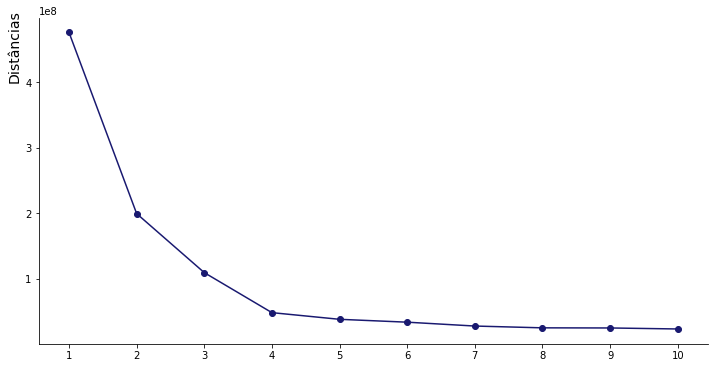

In [7]:
X = dados.iloc[:, 12:]
inertias = []
ks = range(1, 11)

for k in ks:
    model = KMeans(n_clusters=k, init='random')
    model.fit(X)
    inertias.append(model.inertia_)

plt.figure(figsize=(12, 6))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(ks, inertias, '-o', color='#191970')
plt.xlabel(None)
plt.ylabel('Distâncias', fontsize=14, horizontalalignment='left', y=0.80)
plt.xticks(ks)
plt.grid(False)
plt.show()

Agrupamento

In [8]:
kmeans= KMeans(n_clusters=4, random_state=85, init='random')
kmeans.fit(X)
dados['cluster'] = kmeans.labels_
dados.sample()

,fase_dia,tipo_acidente_agrupado,causa_acidente,condicao_metereologica_agrupado,tracado_via,sexo,faixa_etaria,estado_fisico,estacao_do_ano,dia_semana_agrupado,tipo_pista,porte_veiculo,fase_dia_encoder,tipo_acidente_agrupado_encoder,causa_acidente_encoder,condicao_metereologica_agrupado_encoder,tracado_via_encoder,sexo_encoder,faixa_etaria_encoder,estado_fisico_encoder,estacao_do_ano_encoder,dia_semana_agrupado_encoder,tipo_pista_encoder,porte_veiculo_encoder,cluster
1235196,pleno dia,colisão,falta de atencao,ensolarado,reta,feminino,jovem,ileso,primavera,dia útil,dupla,pequeno porte,3,2,39,0,6,0,4,2,2,0,0,3,1


### Análise do agrupamento

In [9]:
print(dados['cluster'].value_counts())

1    699070
3    641834
2    197712
0    168777
Name: cluster, dtype: int64


Cluster 1

In [34]:
cluster_um = dados.query('cluster==0')
cluster_um.drop(X.columns, axis=1, inplace=True)

for col in cluster_um.iloc[:, :12]:
    print(f'Coluna {col}: {cluster_um[col].value_counts().index[0]}')

Coluna fase_dia: pleno dia
Coluna tipo_acidente_agrupado: colisão
Coluna causa_acidente: defeito mecanico no veiculo
Coluna condicao_metereologica_agrupado: ensolarado
Coluna tracado_via: reta
Coluna sexo: masculino
Coluna faixa_etaria: adulto
Coluna estado_fisico: ileso
Coluna estacao_do_ano: inverno
Coluna dia_semana_agrupado: dia útil
Coluna tipo_pista: simples
Coluna porte_veiculo: pequeno porte


Cluster 2

In [35]:
cluster_dois = dados.query('cluster==1')
cluster_dois.drop(X.columns, axis=1, inplace=True)

for col in cluster_dois.iloc[:, :12]:
    print(f'Coluna {col}: {cluster_dois[col].value_counts().index[0]}')

Coluna fase_dia: pleno dia
Coluna tipo_acidente_agrupado: colisão
Coluna causa_acidente: falta de atencao
Coluna condicao_metereologica_agrupado: ensolarado
Coluna tracado_via: reta
Coluna sexo: masculino
Coluna faixa_etaria: adulto
Coluna estado_fisico: ileso
Coluna estacao_do_ano: inverno
Coluna dia_semana_agrupado: dia útil
Coluna tipo_pista: simples
Coluna porte_veiculo: pequeno porte


Cluster 3

In [36]:
cluster_tres = dados.query('cluster==2')
cluster_tres.drop(X.columns, axis=1, inplace=True)

for col in cluster_tres.iloc[:, :12]:
    print(f'Coluna {col}: {cluster_tres[col].value_counts().index[0]}')

Coluna fase_dia: pleno dia
Coluna tipo_acidente_agrupado: colisão
Coluna causa_acidente: velocidade incompativel
Coluna condicao_metereologica_agrupado: ensolarado
Coluna tracado_via: curva
Coluna sexo: masculino
Coluna faixa_etaria: adulto
Coluna estado_fisico: ileso
Coluna estacao_do_ano: verão
Coluna dia_semana_agrupado: dia útil
Coluna tipo_pista: simples
Coluna porte_veiculo: pequeno porte


Cluster 4

In [37]:
cluster_quatro = dados.query('cluster==3')
cluster_quatro.drop(X.columns, axis=1, inplace=True)

for col in cluster_quatro.iloc[:, :12]:
    print(f'Coluna {col}: {cluster_quatro[col].value_counts().index[0]}')

Coluna fase_dia: pleno dia
Coluna tipo_acidente_agrupado: colisão
Coluna causa_acidente: outras
Coluna condicao_metereologica_agrupado: ensolarado
Coluna tracado_via: reta
Coluna sexo: masculino
Coluna faixa_etaria: adulto
Coluna estado_fisico: ileso
Coluna estacao_do_ano: inverno
Coluna dia_semana_agrupado: dia útil
Coluna tipo_pista: simples
Coluna porte_veiculo: pequeno porte
